# 🧾 Intro 
"""
PR#6: Model Explainability (06_model_explain.ipynb)

This notebook explains the predictions of the best model selected in PR#5 (XGBoost) using SHAP values.
We will visualize global and local feature importance to better understand which factors drive the predictions.
"""

In [1]:
# 📦 Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import shap
import joblib
import sys
from sklearn.model_selection import train_test_split

In [2]:
# 🔧 Configure environment
plt.style.use("default")
shap.initjs()

In [3]:
# Extend module path for utils
sys.path.append(str(Path().resolve().parent))
from utils.mood_features import get_mood_index
from utils.feature_engineering import add_lag_features

In [4]:
# ✅ Paths
data_path = Path("../data/cleaned/cleaned_data.csv")
model_path = Path("../models/XGBoost_model.pkl")
output_image_dir = Path("../images/model_explain")
output_image_dir.mkdir(parents=True, exist_ok=True)

In [5]:
# 🔄 Load data & preprocess
df = pd.read_csv(data_path, parse_dates=["Date"])
df = get_mood_index(df)
df = add_lag_features(df)

In [6]:
# Encode Mood Zone
df["Mood_Zone_Cat"] = df["Mood_Zone"].astype("category").cat.codes

In [7]:
# Define target and features
y = df["Target_NextWeekDrop"]
X = df.drop(columns=["Date", "Target_NextWeekDrop", "Mood_Zone"], errors="ignore")

In [8]:
# 🧪 Load best model
best_model = joblib.load(model_path)
print(f"Loaded model: {type(best_model).__name__}")

Loaded model: XGBClassifier


In [9]:
# 🧪 Create same train-test split
RANDOM_STATE = 42
_, X_test, _, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

In [10]:
# 📊 Create SHAP explainer for XGBoost
explainer = shap.TreeExplainer(best_model)
shap_values_raw = explainer.shap_values(X_test)

In [11]:
# ✅ Handle binary vs multiclass robustly
if isinstance(shap_values_raw, list) and len(shap_values_raw) > 1:
    shap_values_class = shap_values_raw[1]
    base_value = explainer.expected_value[1]
else:
    shap_values_class = shap_values_raw
    base_value = explainer.expected_value

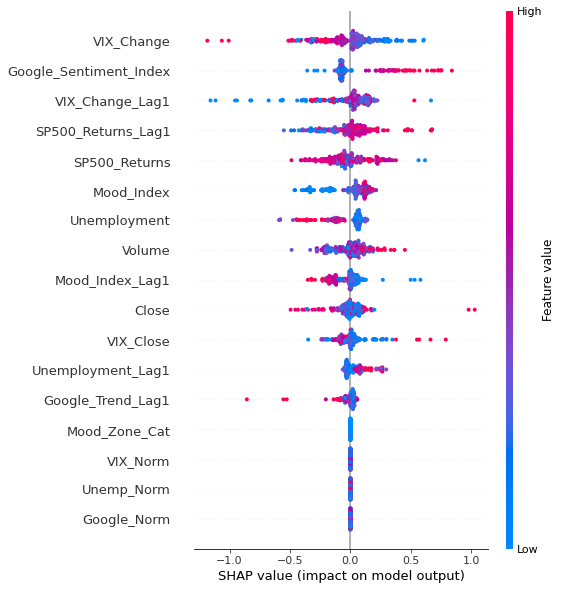

In [12]:
# 📈 SHAP Summary Plot (Global Feature Importance)
plt.figure()
shap.summary_plot(shap_values_class, X_test, show=False)
plt.tight_layout()
plt.savefig(output_image_dir / "shap_beeswarm.png", dpi=300, facecolor="white")
plt.show()

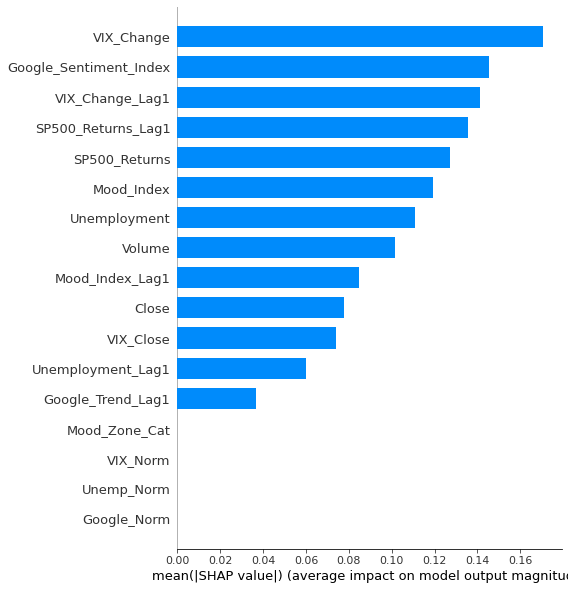

In [13]:
# 📈 SHAP Summary Plot (Global Feature Importance)
plt.figure()
shap.summary_plot(shap_values_class, X_test, plot_type="bar", show=False, max_display=20)
plt.tight_layout()
plt.savefig(output_image_dir / "shap_summary_plot.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

<Figure size 432x288 with 0 Axes>

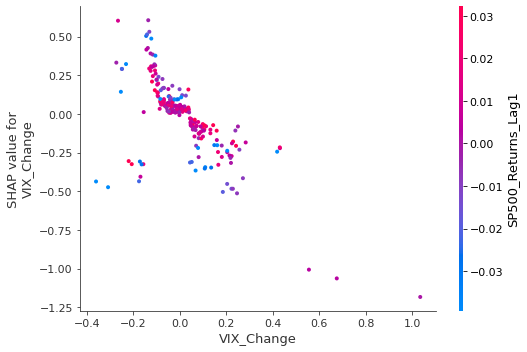

In [14]:
# 📈 SHAP Dependence Plot for Top Feature
top_feature = X_test.columns[np.argsort(np.abs(shap_values_class).mean(0))[-1]]
plt.figure()
shap.dependence_plot(top_feature, shap_values_class, X_test, show=False)
plt.tight_layout()
plt.savefig(output_image_dir / f"shap_dependence_{top_feature}.png", dpi=300, facecolor="white")
plt.show()

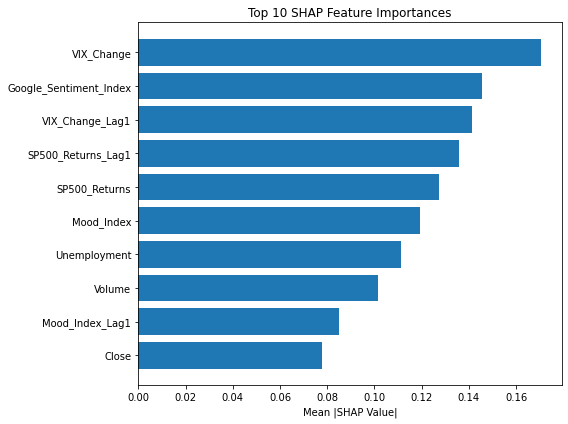

In [15]:
# 📊 Top 10 SHAP Feature Importances
shap_importance = np.abs(shap_values_class).mean(axis=0)

# Create sorted dataframe
importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": shap_importance
}).sort_values(by="Importance", ascending=False)

# Plot using matplotlib
plt.figure(figsize=(8, 6))
plt.barh(importance_df["Feature"].head(10)[::-1], importance_df["Importance"].head(10)[::-1])
plt.xlabel("Mean |SHAP Value|")
plt.title("Top 10 SHAP Feature Importances")
plt.tight_layout()
plt.savefig(output_image_dir / "shap_top10_features.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

In [16]:
# ✅ Pick a single example for Waterfall plot
sample_index = 0
sample = X_test.iloc[sample_index:sample_index + 1]
shap_values_sample = shap_values_class[sample_index]

In [17]:
# 🔍 Debug
print("SHAP values sample (first 5):", shap_values_sample[:5])
print("Base value:", base_value)

SHAP values sample (first 5): [-0.04926192  0.05936727 -0.14998923  0.05676493 -0.07183295]
Base value: 0.0002662191


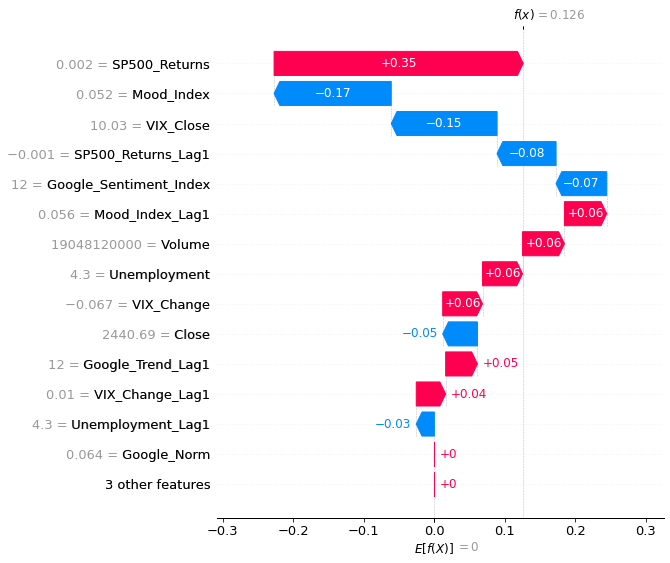

In [18]:
# ✅ Create SHAP Waterfall plot robustly
fig = plt.figure()
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_sample,
        base_values=base_value,
        data=sample.values[0],
        feature_names=X_test.columns
    ),
    max_display=15
)
fig.savefig(output_image_dir / "shap_waterfall_sample.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.close(fig)

# 📌 Conclusion
The SHAP analysis highlights that the most impactful features in the XGBoost model are the engineered mood index and lag-based variables, which align with domain intuition. While the predictive performance remains limited (as observed in PR5 metrics), the explainability step demonstrates how the model interprets these inputs. These insights will be consolidated in PR7 (Final Integrated Notebook) and formally documented in PR8 (Technical Documentation), ensuring a clear linkage between feature design, model behavior, and business interpretation.